(regression)=
# 回帰分析

回帰分析とは，データから二つの変数間の関係を求める手法です。二つの変数xとyとの関係が線型で表されると仮定すると
\begin{equation}
y = ax+b \label{ax+b}
\end{equation}
となります。回帰係数$a$と$b$を機械学習ライブラリ[scikit-learn](https://scikit-learn.org/)を使って求めてみましょう。

## 最小二乗法
　データとの誤差を最小にするには，分散が最小になるように回帰係数を決めます。これを最小二乗法と呼び，得られた回帰係数を最小分散推定量といいます。以下の例では，テストデータを作成して`sklearn.linear_model`の線型回帰`LinearRegression`を使っています。


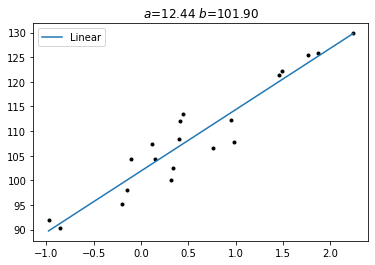

In [3]:
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
 
fig, ax = plt.subplots()
 
rng = np.random.RandomState(0)
X, y = make_regression(n_samples=20, n_features=1, random_state=0,
                      noise=4.0, bias=100.0)
 
ax.plot(X, y, 'k.')
 
x = np.linspace(X.min(), X.max(), 7)
lin = LinearRegression()
lin.fit(X, y)
y_linear = lin.coef_ * x + lin.intercept_
ax.set_title(f"$a$={lin.coef_[0]:.2f} $b$={lin.intercept_:.2f}")
ax.plot(x, y_linear, label="Linear")
ax.legend()

![linear_outliers](figures/linear_outliers.png)

図1 線型回帰。青い実線は<span style="color:red;">●</span>のみ，橙色の実線は外れ値<span style="color:blue;">●</span>を含む全てのデータから推定した場合の回帰直線。

## ロバスト推定

実際のデータには直線から大きく外れた値が含まれることがあります。これを外れ値といいます。最小二乗法は外れ値に大きく影響を受けます。上の例では傾きは正（$a=12.44$）でしたが, わずか4点外れ値が入るだけで負（$a=-4.36$）になってしまいます（図1 橙色の実線）。これは外れ値に近づけた方が全体として分散の和を最も小さくなるからです。

二つの変数の適切な関係を得るために，通常外れ値は除去してから最小二乗法を適用します。ここで問題となるのは，どれだけ外れたものを除去すれば良いかということです。またビッグデータには質の悪い値が混入するする可能性があり，個別に閾値を設け一つ一つ取り除くのは現実的ではありません。さらに厄介なのは，外れ値が意味を持つ場合です。例えば，発達した低気圧や台風の中心が観測点を通過し，周りに比べて低い気圧を観測した場合が該当します。観測網やモデルの解像度が粗い場合は，たまたま観測できた中心気圧は観測点含む領域を代表する値ではない，つまり代表性誤差があるデータとみなされます。一方中心気圧は顕著な現象を捉えた貴重なデータともいえます。

最小二乗法のように推定を大きく変えることがなく，外れ値を含めた推定は可能でしょうか。外れ値が推定に大きな影響を与えてしまったのは，最小分散を得るために大きな重みを与えていたからです。裏返せば，値が外れるほど重みを小さくすればよいということになります。最小二乗法では分散つまり誤差の二乗を規準（ノルム）として誤差を評価しているため，乖離が大きくなると急激に値が大きくなります。二乗の代わりに絶対値をノルムとして用いると，変化は穏やかになります。0に近いところでは二乗，離れたところでは絶対値を用いたものをHuberノルムといいます。Huberノルムに基づくコスト函数を数式で表すと次のようになります。

\begin{equation}
J(\delta x) = 
\begin{cases}
\frac{1}{2}\frac{(\delta x)^2}{\sigma^2} &|\delta x| \le c\\
\frac{1}{2}\frac{c|\delta x|-c^2/2}{\sigma^2}& |\delta x| > c\\
\end{cases} \label{huberloss}
\end{equation}

ここで$J$はコスト函数，$\delta x$はデータとの乖離，$\sigma^2$は誤差分散，$c$は遷移点を表します。乖離の絶対値$|\delta x|$が$c$よりも大きいところでは1次函数，$c$以下では2次函数になっています。

![quadratic-Huberc.png](figures/quadratic-Huberc.png)

図2 二乗ノルムとHuberノルムとの比較。横軸は乖離$\delta x$，縦軸は誤差を評価するコスト函数を表す。青は二乗ノルム，橙はHuberノルム。

高収入の人を含めると，平均年収が高い方に引きずられることはよく知られていますが，外れ値は平均値にも大きく影響します。これに対し，データを順に並べたときに中位になる値である中央値はあまり影響を受けません。外れ値の影響を受けにくい推定手法をロバスト（robust，頑強）推定といいいます。Huberノルムを用いた回帰はロバスト推定の一つです。

scikit-learnの`sklearn.linear_model`の`LinearRegression`を`HuberRegressor`に替えて，遷移点を指定するとHuber回帰ができます。

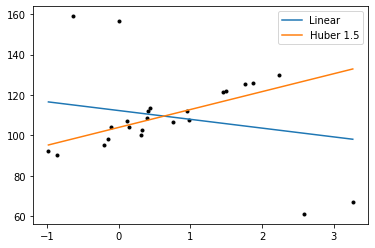

In [20]:
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, HuberRegressor
 
fig, ax = plt.subplots()
 
rng = np.random.RandomState(0)
X, y = make_regression(n_samples=20, n_features=1, random_state=0,
                      noise=4.0, bias=100.0)
 
Xo = rng.normal(0, 0.5, size=(4, 1))
yo = rng.normal(0, 2.0, size=4)
Xo[:2, :] += X.max() + X.mean() / 4
Xo[2:, :] += X.min() - X.mean() / 4
yo[:2] += y.min() - y.mean() / 4
yo[2:] += y.max() + y.mean() / 4
X = np.vstack([X, Xo])
y = np.concatenate([y, yo])
ax.plot(X, y, 'k.')
 
x = np.linspace(X.min(), X.max(), 7)
lin = LinearRegression()
lin.fit(X, y)
y_linear = lin.coef_ * x + lin.intercept_
ax.plot(x, y_linear, label="Linear")
c = 1.5
hub = HuberRegressor(alpha=0.0, epsilon=c)
hub.fit(X, y)
y_huber = hub.coef_ * x + hub.intercept_
ax.plot(x, y_huber, label=f"Huber {c}")
ax.legend()

![Linear_vs_Huber](figures/Linear_vs_Huber.png)

図3 線型回帰（青い実線）とHuber回帰（橙色の実線）。データは図1と同様。

Huber回帰で得られた直線の傾きは$a=8.87$で，外れ値を除いた場合よりやや小さくなりましたが，外れ値の値を強く受けていないことが分かります。Huberノルムは，現業数値予報機関においてラジオゾンデデータ等現場観測の品質管理に用いられています。